In [265]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.patches as patches

from matplotlib.dates import DateFormatter

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import FuncFormatter

from sklearn.metrics import silhouette_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,MinMaxScaler

from unittest.mock import inplace
from IPython.display import set_matplotlib_formats
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split, KFold
from random import randint

from scipy.io import loadmat
import seaborn as sns
import glob
import torch.nn as nn
import torch
import numpy as np
import pandas as pd
import datetime
import math
import time
import datetime
import warnings


warnings.simplefilter(action='ignore', category=FutureWarning)
# plt.rcParams["font.weight"] = "bold"
# plt.rcParams["axes.labelweight"] = "bold"
warnings.filterwarnings(action='ignore')
#그래프에서 음수 값이 나올 때, 깨지는 현상 방지
mpl.rc('axes',unicode_minus=False)

# Korean Font Setting
plt.rcParams["font.family"] = 'Malgun Gothic'

In [266]:
def load_data(battery):
  mat = loadmat(battery + '.mat')
  print('Total data in dataset: ', len(mat[battery][0, 0]['cycle'][0]))
  counter = 0
  dataset = []
  capacity_data = []
  
  for i in range(len(mat[battery][0, 0]['cycle'][0])):
    row = mat[battery][0, 0]['cycle'][0, i]
    if row['type'][0] == 'discharge':
      ambient_temperature = row['ambient_temperature'][0][0]
      date_time = datetime.datetime(int(row['time'][0][0]),
                               int(row['time'][0][1]),
                               int(row['time'][0][2]),
                               int(row['time'][0][3]),
                               int(row['time'][0][4])) + datetime.timedelta(seconds=int(row['time'][0][5]))
      data = row['data']
      capacity = data[0][0]['Capacity'][0][0]
      for j in range(len(data[0][0]['Voltage_measured'][0])):
        voltage_measured = data[0][0]['Voltage_measured'][0][j]
        current_measured = data[0][0]['Current_measured'][0][j]
        temperature_measured = data[0][0]['Temperature_measured'][0][j]
        current_load = data[0][0]['Current_load'][0][j]
        voltage_load = data[0][0]['Voltage_load'][0][j]
        time = data[0][0]['Time'][0][j]
        dataset.append([counter + 1, ambient_temperature, date_time, capacity,
                        voltage_measured, current_measured,
                        temperature_measured, current_load,
                        voltage_load, time])
      capacity_data.append([counter + 1, ambient_temperature, date_time, capacity])
      counter = counter + 1
  print(dataset[0])
  return [pd.DataFrame(data=dataset,
                       columns=['cycle', 'ambient_temperature', 'datetime',
                                'capacity', 'voltage_measured',
                                'current_measured', 'temperature_measured',
                                'current_load', 'voltage_load', 'time']),
          pd.DataFrame(data=capacity_data,
                       columns=['cycle', 'ambient_temperature', 'datetime',
                                'capacity'])]
dataset, capacity = load_data('B0005')
pd.set_option('display.max_columns', 10)
display(dataset)
dataset.describe() 

Total data in dataset:  616
[1, 24, datetime.datetime(2008, 4, 2, 15, 25, 41), 1.8564874208181574, 4.191491807505295, -0.004901589207462691, 24.330033885570543, -0.0006, 0.0, 0.0]


cycle  ambient_temperature            datetime  capacity  \
0          1                   24 2008-04-02 15:25:41  1.856487   
1          1                   24 2008-04-02 15:25:41  1.856487   
2          1                   24 2008-04-02 15:25:41  1.856487   
3          1                   24 2008-04-02 15:25:41  1.856487   
4          1                   24 2008-04-02 15:25:41  1.856487   
...      ...                  ...                 ...       ...   
50280    168                   24 2008-05-27 20:45:42  1.325079   
50281    168                   24 2008-05-27 20:45:42  1.325079   
50282    168                   24 2008-05-27 20:45:42  1.325079   
50283    168                   24 2008-05-27 20:45:42  1.325079   
50284    168                   24 2008-05-27 20:45:42  1.325079   

       voltage_measured  current_measured  temperature_measured  current_load  \
0              4.191492         -0.004902             24.330034       -0.0006   
1              4.190749         -0.001478             24.325993       -0.0006   
2              3.974871         -2.012528             24.389085       -1.9982   
3              3.951717         -2.013979             24.544752       -1.9982   
4              3.934352         -2.011144             24.731385       -1.9982   
...                 ...               ...                   ...           ...   
50280          3.579262         -0.001569             34.864823        0.0006   
50281          3.581964         -0.003067             34.814770        0.0006   
50282          3.584484         -0.003079             34.676258        0.0006   
50283          3.587336          0.001219             34.565580        0.0006   
50284          3.589937         -0.000583             34.405920        0.0006   

       voltage_load      time  
0             0.000     0.000  
1             4.206    16.781  
2             3.062    35.703  
3             3.030    53.781  
4             3.011    71.922  
...             ...       ...  
50280         0.000  2781.312  
50281         0.000  2791.062  
50282         0.000  2800.828  
50283         0.000  2810.640  
50284         0.000  2820.390  

[50285 rows x 10 columns]

cycle  ambient_temperature      capacity  voltage_measured  \
count  50285.000000              50285.0  50285.000000      50285.000000   
mean      88.125942                 24.0      1.560345          3.515268   
std       45.699687                  0.0      0.182380          0.231778   
min        1.000000                 24.0      1.287453          2.455679   
25%       50.000000                 24.0      1.386229          3.399384   
50%       88.000000                 24.0      1.538237          3.511664   
75%      127.000000                 24.0      1.746871          3.660903   
max      168.000000                 24.0      1.856487          4.222920   

       current_measured  temperature_measured  current_load  voltage_load  \
count      50285.000000          50285.000000  50285.000000  50285.000000   
mean          -1.806032             32.816991      1.362700      2.308406   
std            0.610502              3.987515      1.313698      0.800300   
min           -2.029098             23.214802     -1.998400      0.000000   
25%           -2.013415             30.019392      1.998000      2.388000   
50%           -2.012312             32.828944      1.998200      2.533000   
75%           -2.011052             35.920887      1.998200      2.690000   
max            0.007496             41.450232      1.998400      4.238000   

               time  
count  50285.000000  
mean    1546.208924  
std      906.640295  
min        0.000000  
25%      768.563000  
50%     1537.031000  
75%     2305.984000  
max     3690.234000

Text(0.5, 1.0, 'Discharge B0005')

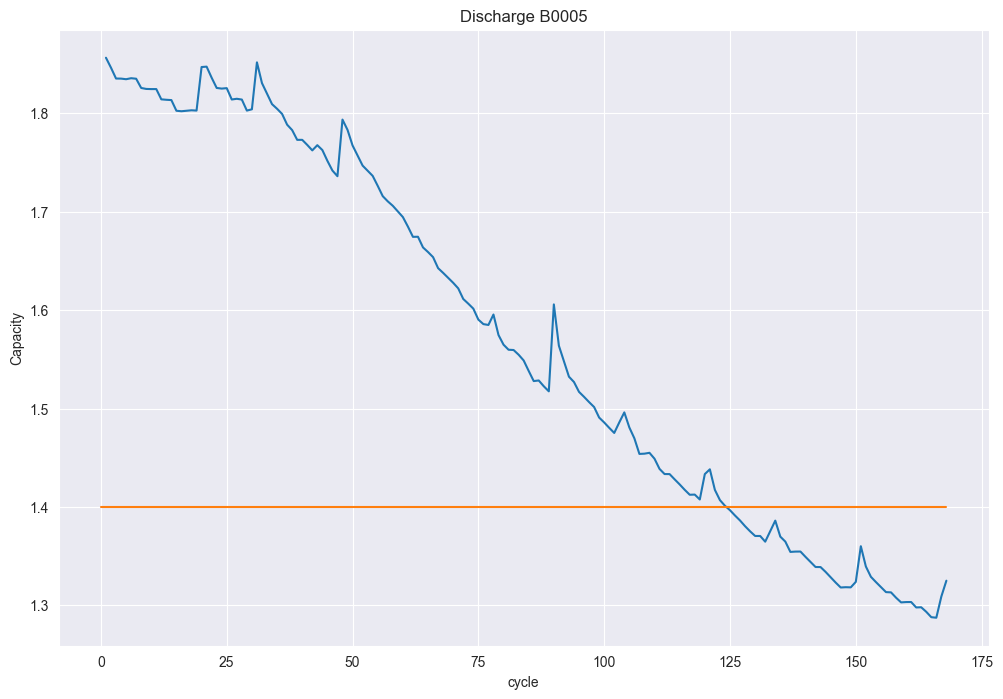

In [267]:
plot_df = capacity.loc[(capacity['cycle']>=1),['cycle','capacity']]
sns.set_style("darkgrid")
plt.figure(figsize=(12, 8))
plt.plot(plot_df['cycle'], plot_df['capacity'])
#Draw threshold
plt.plot([0.,len(capacity)], [1.4, 1.4])
plt.ylabel('Capacity')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.title('Discharge B0005')

In [268]:
attrib=['cycle', 'datetime', 'capacity']
dis_ele = capacity[attrib]
C = dis_ele['capacity'][0]
for i in range(len(dis_ele)):
    dis_ele['SoH']=(dis_ele['capacity'])/C
print(dis_ele.head(5))

   cycle            datetime  capacity       SoH
0      1 2008-04-02 15:25:41  1.856487  1.000000
1      2 2008-04-02 19:43:48  1.846327  0.994527
2      3 2008-04-03 00:01:06  1.835349  0.988614
3      4 2008-04-03 04:16:37  1.835263  0.988567
4      5 2008-04-03 08:33:25  1.834646  0.988235


Text(0.5, 1.0, 'Discharge B0005')

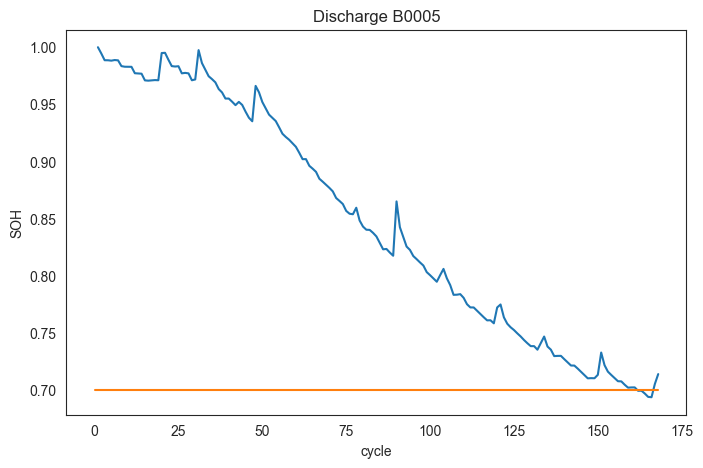

In [269]:
plot_df = dis_ele.loc[(dis_ele['cycle']>=1),['cycle','SoH']]
sns.set_style("white")
plt.figure(figsize=(8, 5))
plt.plot(plot_df['cycle'], plot_df['SoH'])
#Draw threshold
plt.plot([0.,len(capacity)], [0.70, 0.70])
plt.ylabel('SOH')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.title('Discharge B0005')

In [270]:
C = dataset['capacity'][0]
train_test_dict = {}
soh = []
for i in range(len(dataset)):
  soh.append([dataset['capacity'][i] / C])
soh = pd.DataFrame(data=soh, columns=['SoH'])

attribs=['capacity','datetime', 'voltage_measured', 'current_measured',
         'temperature_measured', 'current_load', 'voltage_load', 'time']
train_dataset = dataset[attribs]

train_dataset = train_dataset.groupby(['datetime']).mean()
soh = soh.drop_duplicates(['SoH']).reset_index(drop=True)
display(train_dataset)
display(soh)

train_size = int(len(train_dataset)* 0.8)
train_df = train_dataset[:train_size]
test_df = train_dataset[train_size:]
train_y = soh[:train_size].values.reshape(-1)
test_y = soh[train_size:].values.reshape(-1)

sc = StandardScaler()
sc = sc.fit(train_df)
train_x = sc.transform(train_df)
test_x = sc.transform(test_df)

print(test_y.shape)
train_test_dict['train_x'], train_test_dict['train_y'] = train_x, train_y
train_test_dict['test_x'], train_test_dict['test_y'] = test_x, test_y

capacity  voltage_measured  current_measured  \
datetime                                                            
2008-04-02 15:25:41  1.856487          3.529829         -1.818702   
2008-04-02 19:43:48  1.846327          3.537320         -1.817560   
2008-04-03 00:01:06  1.835349          3.543737         -1.816487   
2008-04-03 04:16:37  1.835263          3.543666         -1.825589   
2008-04-03 08:33:25  1.834646          3.542343         -1.826114   
...                       ...               ...               ...   
2008-05-26 10:44:38  1.293464          3.466462         -1.674488   
2008-05-26 15:30:43  1.288003          3.468509         -1.667447   
2008-05-26 20:21:04  1.287453          3.466806         -1.667470   
2008-05-27 15:52:41  1.309015          3.471071         -1.688898   
2008-05-27 20:45:42  1.325079          3.475472         -1.697928   

                     temperature_measured  current_load  voltage_load  \
datetime                                                                
2008-04-02 15:25:41             32.572328     -1.805570      2.404944   
2008-04-02 19:43:48             32.725235     -1.804583      2.399260   
2008-04-03 00:01:06             32.642862     -1.803575      2.397969   
2008-04-03 04:16:37             32.514876     -1.812863      2.408289   
2008-04-03 08:33:25             32.382349     -1.812876      2.408505   
...                                   ...           ...           ...   
2008-05-26 10:44:38             33.275688      1.661799      2.073168   
2008-05-26 15:30:43             33.320678      1.655086      2.064189   
2008-05-26 20:21:04             33.373150      1.655103      2.062717   
2008-05-27 15:52:41             33.713519      1.676430      2.107460   
2008-05-27 20:45:42             33.865318      1.685264      2.120230   

                            time  
datetime                          
2008-04-02 15:25:41  1812.087497  
2008-04-02 19:43:48  1803.143372  
2008-04-03 00:01:06  1793.809379  
2008-04-03 04:16:37  1784.359428  
2008-04-03 08:33:25  1783.501351  
...                          ...  
2008-05-26 10:44:38  1388.981387  
2008-05-26 15:30:43  1389.304451  
2008-05-26 20:21:04  1388.685185  
2008-05-27 15:52:41  1393.789745  
2008-05-27 20:45:42  1403.070957  

[168 rows x 7 columns]

SoH
0    1.000000
1    0.994527
2    0.988614
3    0.988567
4    0.988235
..        ...
163  0.696726
164  0.693785
165  0.693488
166  0.705103
167  0.713756

[168 rows x 1 columns]

(34,)


In [271]:
import torch.nn as nn
import torch
import torch.nn.init as init
import torch.nn.functional as F
import numpy as np
from torch.utils import data

class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""

    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: 'checkpoint.pt'
        """

        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.best_model = model
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
            self.best_score = score
            return self.best_model
        else:
            print(f'Validation loss decreased ({-self.best_score:.6f} --> {val_loss:.6f}).')
            self.best_score = score
            self.best_model = model
            # self.save_checkpoint(val_loss, model)
            self.counter = 0
            return self.best_model

    def save_checkpoint(self, val_loss, model):
        '''validation loss가 감소하면 모델을 저장한다.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).')
        # torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


# torch data loader 에 넣어주기 위한 Dataset class

class My_Dataset(data.Dataset):
    def __init__(self, data, labels):
        super().__init__()
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


class Model_Learner():

    def __init__(self, DEVICE, type='dnn'):
        self.DEVICE = DEVICE
        self.type = type
        self.train_dict = {'dnn': self.dnn_train, 'lstm': self.lstm_train} # 각 model type에 따라 train 함수를 다르게 호출한다.
        self.eval_dict = {'dnn': self.dnn_evaluate, 'lstm': self.lstm_evaluate} # 각 model type에 따라 evaluate 함수를 다르게 호출한다.


    # 모델 별로 학습을 하기 위한 함수
    def nn_learning(self, nn_model, ls_dict, data_dict):

        optimizer = torch.optim.Adam(nn_model.parameters(), lr=ls_dict['learning_rate'])

        train_loader = torch.utils.data.DataLoader(dataset=My_Dataset(data_dict['train_x'], data_dict['train_y']), # 시계열 데이터 이므로 shuffle 도 하지 않고, batch로 나누어지지 않는 값 또한 drop 하지 않는다.
                                                   batch_size=ls_dict['BATCH_SIZE'], shuffle=False, drop_last=False)

        test_loader = torch.utils.data.DataLoader(dataset=My_Dataset(data_dict['test_x'], data_dict['test_y']), # 시계열 데이터 이므로 shuffle 도 하지 않고, batch로 나누어지지 않는 값 또한 drop 하지 않는다.
                                                  batch_size=ls_dict['BATCH_SIZE'], shuffle=False, drop_last=False)

        criterion = torch.nn.MSELoss().to(self.DEVICE)
        test_loss = 0
        correct = 0
        patience = ls_dict['patience']

        self.avg_train_losses = []
        self.avg_valid_losses = []

        early_stopping = EarlyStopping(patience=patience, verbose=True)
        best_model = None

        for epoch in range(1, ls_dict['EPOCHS'] + 1):
            train_loss = self.train_dict[self.type](nn_model, train_loader, optimizer, criterion)
            test_loss = self.eval_dict[self.type](nn_model, test_loader, criterion)

            self.avg_train_losses.append(train_loss)
            self.avg_valid_losses.append(test_loss)

            if epoch % 10 == 0:
                print('epoch:{} train_loss:{:.4f}'.format(epoch, train_loss))
                print('validation_loss:{:.4f}'.format(test_loss))
                best_model = early_stopping(test_loss, nn_model)
                if early_stopping.early_stop:
                    print("Early stopping")
                    break

        best_model.eval()

        output = best_model(torch.from_numpy(data_dict['test_x'].astype(np.float32)).to(self.DEVICE)).cpu().squeeze()

        self.output_np = output.detach().numpy()

        return best_model, self.output_np

    def dnn_train(self, model, train_loader, optimizer, criterion):
        try:
            model.train()
            train_loss = 0

            for batch_idx, (data, target) in enumerate(train_loader):
                data, target = data.to(self.DEVICE), target.type(torch.float32).to(self.DEVICE)
                optimizer.zero_grad()
                hypothesis = model(data.type(torch.float32)).squeeze()
                loss = criterion(hypothesis, target)
                train_loss += loss
                loss.backward()
                optimizer.step()
            train_loss /= len(train_loader.dataset)
            return train_loss

        except Exception as e:
            print('train:', e)

    def lstm_train(self, model, train_loader, optimizer, criterion):
        try:
            model.train()
            train_loss = 0

            for batch_idx, (data, target) in enumerate(train_loader):
                data, target = data.to(self.DEVICE), target.type(torch.float32).to(self.DEVICE)
                model.reset_hidden_state()
                hypothesis = model(data.type(torch.float32))
                
                loss = criterion(hypothesis, target)

                optimizer.zero_grad()
                train_loss += loss
                loss.backward()
                optimizer.step()
            train_loss /= len(train_loader.dataset)
            return train_loss

        except Exception as e:
            print('train:', e)

    def dnn_evaluate(self, model, test_loader, criterion):
        try:
            model.eval()
            test_loss = 0


            with torch.no_grad():
                for data, target in test_loader:
                    data, target = data.to(self.DEVICE), target.type(torch.float32).to(self.DEVICE)

                    hypothesis = model(data.type(torch.float32)).squeeze()
                    test_loss += criterion(hypothesis, target)

            test_loss /= len(test_loader.dataset)

            return test_loss
        except Exception as e:
            print('evaluate', e)

    def lstm_evaluate(self, model, test_loader, criterion):
        try:
            model.eval()
            test_loss = 0


            with torch.no_grad():
                for data, target in test_loader:
                    data, target = data.to(self.DEVICE), target.type(torch.float32).to(self.DEVICE)
                    model.reset_hidden_state()

                    hypothesis = model(data.type(torch.float32))
                    test_loss += criterion(hypothesis, target)

            test_loss /= len(test_loader.dataset)

            return test_loss
        except Exception as e:
            print('evaluate', e)

In [272]:
import torch.nn.init as init

class Dense_Net(nn.Module):
    def __init__(self,input_size,n_out):
        super().__init__()
        self.n_out = n_out
        self.enc_size = [input_size, 8,8]

        self.layers = nn.ModuleList([self._make_block(in_f, out_f) for in_f, out_f in zip(self.enc_size, self.enc_size[1:])]) # enc_size를 기준으로 mlp block 생성,
        self.output_layer = nn.Linear(self.enc_size[-1], self.n_out)

        self.dropout_p = 0.1
        self.drop_layer = nn.Dropout(p=self.dropout_p) # Linear Layer 통과 시 마다 drop out 진행 

        for m in self.modules():
            if isinstance(m, nn.Linear):
                init.xavier_normal_(m.weight.data)  # Linear Layer에 대한 xavier weight normalize, batch norm 쓰고 있어서 굳이 사용안해도 됨.

    def forward(self, x):
        for layer in self.layers:
          x = layer(x)
          x = self.drop_layer(x)
        x = self.output_layer(x)
        return x

    def _make_block(self, input_num, output_num): # linear - batchnorm - Relu 구조가 1 block
        return nn.Sequential(
            nn.Linear(input_num, output_num),
            nn.BatchNorm1d(output_num),
            nn.ReLU())



class LSTM(nn.Module):
    def __init__(self,input_size,hidden_dim,seq_len, layers, n_out):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.layers = layers
        self.n_out = n_out

        self.lstm = nn.LSTM(input_size, self.hidden_dim, num_layers=self.layers,batch_first=True) # LSTM layer
        self.fc = nn.Linear(self.hidden_dim, self.n_out, bias = True) 

    def reset_hidden_state(self): 
        self.hidden = (torch.zeros(self.layers, self.seq_len, self.hidden_dim), # 
                       torch.zeros(self.layers, self.seq_len, self.hidden_dim))

    def forward(self, x):
        x, _status = self.lstm(x)
        x = self.fc(x[:, -1])
        return x


In [273]:
import torch
import random

torch.manual_seed(4)
np.random.seed(10)
random.seed(0)

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")


print(DEVICE)

ls_dict = {'learning_rate': 1e-1, 'EPOCHS': 20, 'BATCH_SIZE': 50, 'patience': 5}


train_model = Dense_Net(train_test_dict['train_x'].shape[1], 1)
print(train_model)

net_learning = Model_Learner(DEVICE=DEVICE, type='dnn')
wc_mlp_best, pred_df = net_learning.nn_learning(nn_model=train_model,
                                                ls_dict=ls_dict,
                                                data_dict=train_test_dict)


y = torch.from_numpy(train_test_dict['test_y'].astype(np.float32)).cpu()
y_df = y.numpy()

score = pred_df - y_df

pred_y_df = pd.DataFrame(pred_df, columns=['Predict'])

cpu
Dense_Net(
  (layers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=7, out_features=8, bias=True)
      (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=8, out_features=8, bias=True)
      (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (output_layer): Linear(in_features=8, out_features=1, bias=True)
  (drop_layer): Dropout(p=0.1, inplace=False)
)
epoch:10 train_loss:0.0002
validation_loss:0.0001
Validation loss decreased (inf --> 0.000085).
epoch:20 train_loss:0.0002
validation_loss:0.0000
Validation loss decreased (0.000085 --> 0.000016).


In [274]:
plt.plot(pred_y_df.values)


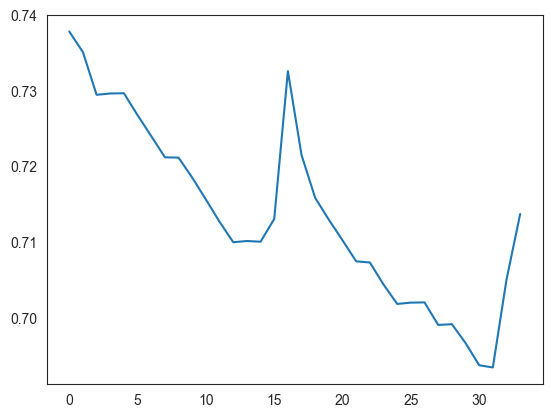

In [275]:
plt.plot(test_y)

In [276]:
dataset_val, capacity_val = load_data('B0006')
attrib=['cycle', 'datetime', 'capacity']
dis_ele = capacity_val[attrib]
C = dis_ele['capacity'][0]
for i in range(len(dis_ele)):
    dis_ele['SoH']=(dis_ele['capacity']) / C
display(dataset_val.head(5))
display(dis_ele.head(5))

Total data in dataset:  616
[1, 24, datetime.datetime(2008, 4, 2, 15, 25, 41), 2.035337591005598, 4.179799607333447, -0.0023663271409738672, 24.277567510331888, -0.0006, 0.0, 0.0]


cycle  ambient_temperature            datetime  capacity  voltage_measured  \
0      1                   24 2008-04-02 15:25:41  2.035338          4.179800   
1      1                   24 2008-04-02 15:25:41  2.035338          4.179823   
2      1                   24 2008-04-02 15:25:41  2.035338          3.966528   
3      1                   24 2008-04-02 15:25:41  2.035338          3.945886   
4      1                   24 2008-04-02 15:25:41  2.035338          3.930354   

   current_measured  temperature_measured  current_load  voltage_load    time  
0         -0.002366             24.277568       -0.0006         0.000   0.000  
1          0.000434             24.277073       -0.0006         4.195  16.781  
2         -2.014242             24.366226       -1.9990         3.070  35.703  
3         -2.008730             24.515123       -1.9990         3.045  53.781  
4         -2.013381             24.676053       -1.9990         3.026  71.922

cycle            datetime  capacity       SoH
0      1 2008-04-02 15:25:41  2.035338  1.000000
1      2 2008-04-02 19:43:48  2.025140  0.994990
2      3 2008-04-03 00:01:06  2.013326  0.989185
3      4 2008-04-03 04:16:37  2.013285  0.989165
4      5 2008-04-03 08:33:25  2.000528  0.982898

In [277]:
attribs=['capacity','datetime', 'voltage_measured', 'current_measured',
         'temperature_measured', 'current_load', 'voltage_load', 'time']
test_set = dataset_val[attribs]

test_set = test_set.groupby(['datetime']).mean()
# train_dataset = train_dataset.drop(['datetime'], axis=1).reset_index(drop=True)
soh = dis_ele['SoH']
display(test_set)
display(soh)

test_data = sc.transform(test_set)
target = soh.values.reshape(-1)
print(target.shape)
print(test_data.shape)

capacity  voltage_measured  current_measured  \
datetime                                                            
2008-04-02 15:25:41  2.035338          3.556946         -1.990533   
2008-04-02 19:43:48  2.025140          3.561476         -1.990278   
2008-04-03 00:01:06  2.013326          3.566752         -1.989947   
2008-04-03 04:16:37  2.013285          3.568795         -1.989601   
2008-04-03 08:33:25  2.000528          3.563971         -1.989548   
...                       ...               ...               ...   
2008-05-26 10:44:38  1.153818          3.414810         -1.516972   
2008-05-26 15:30:43  1.164401          3.416618         -1.523850   
2008-05-26 20:21:04  1.158797          3.412134         -1.523793   
2008-05-27 15:52:41  1.174975          3.419700         -1.539131   
2008-05-27 20:45:42  1.185675          3.423469         -1.542670   

                     temperature_measured  current_load  voltage_load  \
datetime                                                                
2008-04-02 15:25:41             32.142778     -1.978823      2.650081   
2008-04-02 19:43:48             32.293075     -1.978668      2.655776   
2008-04-03 00:01:06             32.244147     -1.978533      2.661800   
2008-04-03 04:16:37             32.147117     -1.978410      2.664144   
2008-04-03 08:33:25             32.066873     -1.978438      2.659418   
...                                   ...           ...           ...   
2008-05-26 10:44:38             33.472459      1.507735      1.853327   
2008-05-26 15:30:43             33.582104      1.514482      1.863027   
2008-05-26 20:21:04             33.663461      1.514489      1.859949   
2008-05-27 15:52:41             33.730546      1.529580      1.889470   
2008-05-27 20:45:42             33.891282      1.532807      1.897450   

                            time  
datetime                          
2008-04-02 15:25:41  1812.087497  
2008-04-02 19:43:48  1803.143372  
2008-04-03 00:01:06  1793.809379  
2008-04-03 04:16:37  1784.359428  
2008-04-03 08:33:25  1783.501351  
...                          ...  
2008-05-26 10:44:38  1388.981387  
2008-05-26 15:30:43  1389.304451  
2008-05-26 20:21:04  1388.685185  
2008-05-27 15:52:41  1393.789745  
2008-05-27 20:45:42  1403.070957  

[168 rows x 7 columns]

0      1.000000
1      0.994990
2      0.989185
3      0.989165
4      0.982898
         ...   
163    0.566893
164    0.572092
165    0.569339
166    0.577287
167    0.582545
Name: SoH, Length: 168, dtype: float64

(168,)
(168, 7)


In [278]:
wc_mlp_best.eval()

output = wc_mlp_best(torch.from_numpy(test_data.astype(np.float32)).to(DEVICE)).cpu().squeeze()

output_np = output.detach().numpy()


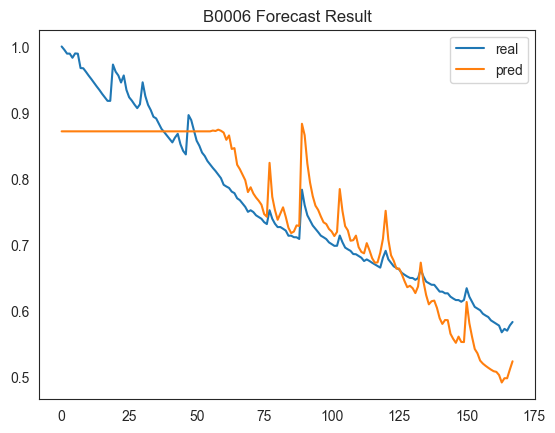

In [279]:
plt.plot(target, label='real')
plt.plot(output_np, label='pred')
plt.title('B0006 Forecast Result')
plt.legend(loc='best')

In [280]:
import shap

In [281]:
explainer = shap.DeepExplainer(wc_mlp_best,torch.from_numpy(train_test_dict['train_x'].astype(np.float32)).to(DEVICE))

shap_values = explainer.shap_values(torch.from_numpy(train_test_dict['test_x'].astype(np.float32)).to(DEVICE))

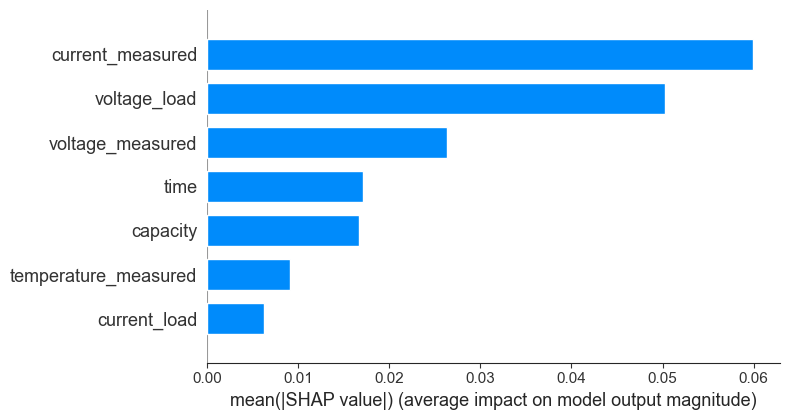

In [282]:
shap.initjs()
X_test = pd.DataFrame(train_test_dict['test_x'], columns=train_dataset.columns)
shap.summary_plot(shap_values, X_test, plot_type="bar")

## LSTM

In [283]:
## time series sequence feature 

def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series) - (seq_length)):
        _x = time_series[i:i + seq_length, :]
        _y = time_series[i + seq_length, -1]
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)


In [284]:
lstm_df = train_dataset

lstm_df['SoH'] = soh.values
lstm_df

capacity  voltage_measured  current_measured  \
datetime                                                            
2008-04-02 15:25:41  1.856487          3.529829         -1.818702   
2008-04-02 19:43:48  1.846327          3.537320         -1.817560   
2008-04-03 00:01:06  1.835349          3.543737         -1.816487   
2008-04-03 04:16:37  1.835263          3.543666         -1.825589   
2008-04-03 08:33:25  1.834646          3.542343         -1.826114   
...                       ...               ...               ...   
2008-05-26 10:44:38  1.293464          3.466462         -1.674488   
2008-05-26 15:30:43  1.288003          3.468509         -1.667447   
2008-05-26 20:21:04  1.287453          3.466806         -1.667470   
2008-05-27 15:52:41  1.309015          3.471071         -1.688898   
2008-05-27 20:45:42  1.325079          3.475472         -1.697928   

                     temperature_measured  current_load  voltage_load  \
datetime                                                                
2008-04-02 15:25:41             32.572328     -1.805570      2.404944   
2008-04-02 19:43:48             32.725235     -1.804583      2.399260   
2008-04-03 00:01:06             32.642862     -1.803575      2.397969   
2008-04-03 04:16:37             32.514876     -1.812863      2.408289   
2008-04-03 08:33:25             32.382349     -1.812876      2.408505   
...                                   ...           ...           ...   
2008-05-26 10:44:38             33.275688      1.661799      2.073168   
2008-05-26 15:30:43             33.320678      1.655086      2.064189   
2008-05-26 20:21:04             33.373150      1.655103      2.062717   
2008-05-27 15:52:41             33.713519      1.676430      2.107460   
2008-05-27 20:45:42             33.865318      1.685264      2.120230   

                            time       SoH  
datetime                                    
2008-04-02 15:25:41  1812.087497  1.000000  
2008-04-02 19:43:48  1803.143372  0.994990  
2008-04-03 00:01:06  1793.809379  0.989185  
2008-04-03 04:16:37  1784.359428  0.989165  
2008-04-03 08:33:25  1783.501351  0.982898  
...                          ...       ...  
2008-05-26 10:44:38  1388.981387  0.566893  
2008-05-26 15:30:43  1389.304451  0.572092  
2008-05-26 20:21:04  1388.685185  0.569339  
2008-05-27 15:52:41  1393.789745  0.577287  
2008-05-27 20:45:42  1403.070957  0.582545  

[168 rows x 8 columns]

In [285]:
train_size = int(len(lstm_df) * 0.8)
lstm_train = lstm_df[:train_size]
lstm_test = lstm_df[train_size:]

In [287]:

seq_length= 7
sc_l = StandardScaler()
sc_y = StandardScaler()


sc_l = sc_l.fit(lstm_train.iloc[:, :-1])
sc_y = sc_y.fit(lstm_train.iloc[:, [-1]])

lstm_train.iloc[:, :-1] = sc_l.transform(lstm_train.iloc[:, :-1])
lstm_test.iloc[:, :-1] = sc_l.transform(lstm_test.iloc[:, :-1])


lstm_train.iloc[:, [-1]] = sc_y.transform(lstm_train.iloc[:, [-1]])
lstm_test.iloc[:, [-1]] = sc_y.transform(lstm_test.iloc[:, [-1]])


normed_trainX, normed_trainY  = build_dataset(lstm_train.values, seq_length)
normed_testX, normed_testY = build_dataset(lstm_test.values, seq_length)

In [288]:
train_test_lstm_dict = {}

train_test_lstm_dict['train_x'], train_test_lstm_dict['train_y'] = normed_trainX, normed_trainY 
train_test_lstm_dict['test_x'],train_test_lstm_dict['test_y'] = normed_testX, normed_testY 


In [289]:
hidden_dim = 10 
output_dim = 1 
learning_rate = 0.01
nb_epochs = 100

torch.manual_seed(3)
np.random.seed(10)
random.seed(0)

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")


print(DEVICE)

ls_dict = {'learning_rate': 1e-1, 'EPOCHS': 20, 'BATCH_SIZE': 50, 'patience': 5}


train_model = LSTM(input_size=train_test_lstm_dict['train_x'].shape[2], hidden_dim=hidden_dim, seq_len=seq_length, n_out=1, layers=1)
print(train_model)

net_learning = Model_Learner(DEVICE=DEVICE, type='lstm')
wc_lstm_best, pred_df = net_learning.nn_learning(nn_model=train_model,
                                                ls_dict=ls_dict,
                                                data_dict=train_test_lstm_dict)


y = torch.from_numpy(train_test_lstm_dict['test_y'].astype(np.float32)).cpu()
y_df = y.numpy()

score = pred_df - y_df

pred_y_df = pd.DataFrame(pred_df, columns=['Predict'])

cpu
LSTM(
  (lstm): LSTM(8, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)
epoch:10 train_loss:0.0026
validation_loss:0.0113
Validation loss decreased (inf --> 0.011277).
epoch:20 train_loss:0.0024
validation_loss:0.0095
Validation loss decreased (0.011277 --> 0.009456).


In [290]:
y

tensor([-1.5701, -1.5936, -1.5932, -1.6403, -1.6658, -1.6880, -1.6881, -1.7115,
        -1.6872, -1.5220, -1.6413, -1.7120, -1.7840, -1.8067, -1.8311, -1.8794,
        -1.9044, -1.9258, -1.9726, -1.9972, -2.0222, -2.0453, -2.1396, -2.0916,
        -2.1170, -2.0435, -1.9949])

In [291]:
pred_y_df

Predict
0  -1.326198
1  -1.329730
2  -1.347441
3  -1.349813
4  -1.348231
5  -1.340162
6  -1.343759
7  -1.360962
8  -1.360656
9  -1.339272
10 -1.315033
11 -1.340419
12 -1.341500
13 -1.346832
14 -1.348708
15 -1.351625
16 -1.355887
17 -1.360013
18 -1.362402
19 -1.369235
20 -1.372337
21 -1.375976
22 -1.378334
23 -1.377752
24 -1.383035
25 -1.386568
26 -1.378817

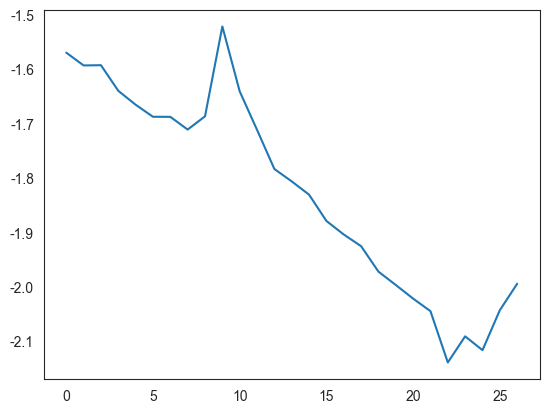

In [292]:
plt.plot(train_test_lstm_dict['test_y'])

<AxesSubplot:>

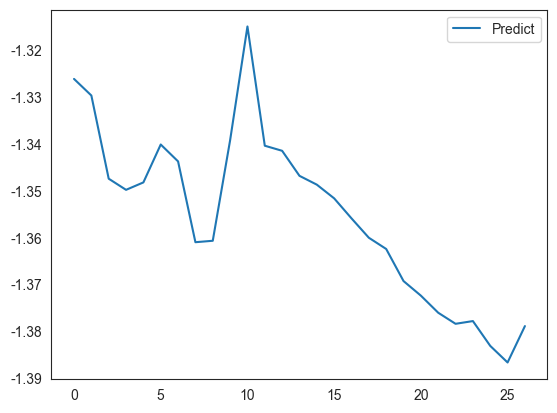

In [293]:
pred_y_df.plot()

In [294]:
dataset_val, capacity_val = load_data('B0006')
attrib=['cycle', 'datetime', 'capacity']
dis_ele = capacity_val[attrib]
C = dis_ele['capacity'][0]
for i in range(len(dis_ele)):
    dis_ele['SoH']=(dis_ele['capacity']) / C
display(dataset_val.head(5))
display(dis_ele.head(5))

Total data in dataset:  616
[1, 24, datetime.datetime(2008, 4, 2, 15, 25, 41), 2.035337591005598, 4.179799607333447, -0.0023663271409738672, 24.277567510331888, -0.0006, 0.0, 0.0]


cycle  ambient_temperature            datetime  capacity  voltage_measured  \
0      1                   24 2008-04-02 15:25:41  2.035338          4.179800   
1      1                   24 2008-04-02 15:25:41  2.035338          4.179823   
2      1                   24 2008-04-02 15:25:41  2.035338          3.966528   
3      1                   24 2008-04-02 15:25:41  2.035338          3.945886   
4      1                   24 2008-04-02 15:25:41  2.035338          3.930354   

   current_measured  temperature_measured  current_load  voltage_load    time  
0         -0.002366             24.277568       -0.0006         0.000   0.000  
1          0.000434             24.277073       -0.0006         4.195  16.781  
2         -2.014242             24.366226       -1.9990         3.070  35.703  
3         -2.008730             24.515123       -1.9990         3.045  53.781  
4         -2.013381             24.676053       -1.9990         3.026  71.922

cycle            datetime  capacity       SoH
0      1 2008-04-02 15:25:41  2.035338  1.000000
1      2 2008-04-02 19:43:48  2.025140  0.994990
2      3 2008-04-03 00:01:06  2.013326  0.989185
3      4 2008-04-03 04:16:37  2.013285  0.989165
4      5 2008-04-03 08:33:25  2.000528  0.982898

In [296]:
attribs=['capacity','datetime', 'voltage_measured', 'current_measured',
         'temperature_measured', 'current_load', 'voltage_load', 'time']
test_set = dataset_val[attribs]

test_set = test_set.groupby(['datetime']).mean()
lstm_test = test_set
lstm_test['SoH'] = dis_ele['SoH'].values

display(lstm_test)
lstm_test.iloc[:, :-1] = sc_l.transform(lstm_test.iloc[:, :-1])
lstm_test.iloc[:, [-1]] = sc_y.transform(lstm_test.iloc[:, [-1]])


testx, testy = build_dataset(lstm_test.values, seq_length)
print(testx.shape)

capacity  voltage_measured  current_measured  \
datetime                                                            
2008-04-02 15:25:41  2.035338          3.556946         -1.990533   
2008-04-02 19:43:48  2.025140          3.561476         -1.990278   
2008-04-03 00:01:06  2.013326          3.566752         -1.989947   
2008-04-03 04:16:37  2.013285          3.568795         -1.989601   
2008-04-03 08:33:25  2.000528          3.563971         -1.989548   
...                       ...               ...               ...   
2008-05-26 10:44:38  1.153818          3.414810         -1.516972   
2008-05-26 15:30:43  1.164401          3.416618         -1.523850   
2008-05-26 20:21:04  1.158797          3.412134         -1.523793   
2008-05-27 15:52:41  1.174975          3.419700         -1.539131   
2008-05-27 20:45:42  1.185675          3.423469         -1.542670   

                     temperature_measured  current_load  voltage_load  \
datetime                                                                
2008-04-02 15:25:41             32.142778     -1.978823      2.650081   
2008-04-02 19:43:48             32.293075     -1.978668      2.655776   
2008-04-03 00:01:06             32.244147     -1.978533      2.661800   
2008-04-03 04:16:37             32.147117     -1.978410      2.664144   
2008-04-03 08:33:25             32.066873     -1.978438      2.659418   
...                                   ...           ...           ...   
2008-05-26 10:44:38             33.472459      1.507735      1.853327   
2008-05-26 15:30:43             33.582104      1.514482      1.863027   
2008-05-26 20:21:04             33.663461      1.514489      1.859949   
2008-05-27 15:52:41             33.730546      1.529580      1.889470   
2008-05-27 20:45:42             33.891282      1.532807      1.897450   

                            time       SoH  
datetime                                    
2008-04-02 15:25:41  1812.087497  1.000000  
2008-04-02 19:43:48  1803.143372  0.994990  
2008-04-03 00:01:06  1793.809379  0.989185  
2008-04-03 04:16:37  1784.359428  0.989165  
2008-04-03 08:33:25  1783.501351  0.982898  
...                          ...       ...  
2008-05-26 10:44:38  1388.981387  0.566893  
2008-05-26 15:30:43  1389.304451  0.572092  
2008-05-26 20:21:04  1388.685185  0.569339  
2008-05-27 15:52:41  1393.789745  0.577287  
2008-05-27 20:45:42  1403.070957  0.582545  

[168 rows x 8 columns]

(161, 7, 8)


In [297]:
wc_lstm_best.eval()
wc_lstm_best.reset_hidden_state()
output = wc_lstm_best(torch.from_numpy(testx.astype(np.float32)).to(DEVICE)).cpu()

output_np = output.detach().numpy()



Text(0.5, 1.0, 'B0006 Forecasting Result')

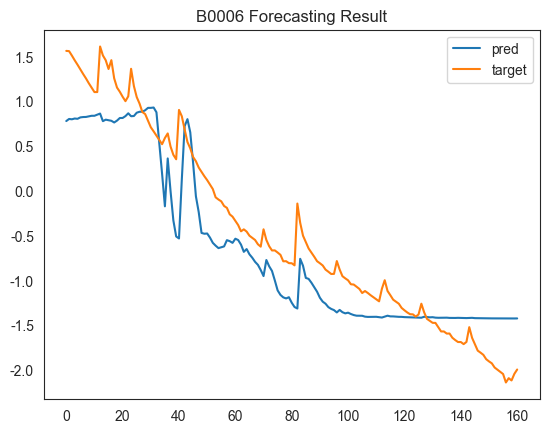

In [298]:
plt.plot(output_np, label = 'pred')
plt.plot(testy, label ='target')
plt.legend(loc='best')
plt.title('B0006 Forecasting Result')

In [299]:
explainer = shap.DeepExplainer(wc_lstm_best,torch.from_numpy(train_test_lstm_dict['train_x'].astype(np.float32)).to(DEVICE))

shap_values = explainer.shap_values(torch.from_numpy(testx.astype(np.float32)).to(DEVICE))

In [300]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0],train_dataset.columns)